<a href="https://colab.research.google.com/github/daa103/DAA_ESAA/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C_ch9_5_pg_579~590.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**05 콘텐츠기반 필터링 실습-TMDB 5000영화 데이터 세트**

**장르속성을 이용한 영화 콘텐츠 기반 필터링**
- 특정 영화를 감상하고 그것이 좋았다면 비슷한 속성, 특성, 구성요소를 가진 다른 영화를 추천한다.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')

In [4]:
movies = pd.read_csv('/content/tmdb_5000_movies.csv')
print(movies.shape)
movies.head(1)

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


4803개의 레코드와 20개의 피처로 구성/
주요 칼럼만 추출해 새로운 DataFrame만든다.

In [5]:
movies_df = movies[['id', 'title', 'genres', 'vote_average', 'vote_count', 'popularity', 'keywords', 'overview']]

파이썬 리스트 내부에 여러개 딕셔너리 있는 형태의 문자열은 한꺼번에 여러개 값을 표현하기 위한 방식이다.

단순히 문자열 형태로 로딩되므로 칼럼을 가공해야 필요한 정보를 추출할 수 있다. 칼럼이 어떤 형태로 되어 있는지 확인 필수

In [6]:
pd.set_option('max_colwidth', 100)
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""sp..."


genre칼럼은 여러개의 개별 장르 데이터를 가지고 있고 이 개별 장르 명칭은 딕서녀리의 키인 name으로 추출할 수 있다.

파이썬 ast모듈의 literal_eval()함수를 이용하면 문자열이 의미하는 list[dict1,dict2] 객체로 만들 수 있다.

In [7]:
from ast import literal_eval
movies_df['genres'] = movies_df['genres'].apply(literal_eval)
movies_df['keywords'] = movies_df['keywords'].apply(literal_eval)

genre칼럼은 리스트 내부에 여러 장르 딕셔너리로 구성된 객체를 가진다.

In [8]:
movies_df['genres'] = movies_df['genres'].apply(lambda x : [ y['name'] for y in x])
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : [ y['name'] for y in x])
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colony, society, space travel, futuristic, romance, spa..."


**장르콘텐츠 유사도 측정**

장르를 문자열로 변경하고 CountVectorizer로 피처벡터화한 행렬데이터값을 코사인 유사도로 비교

- 문자열로 변환된 genres칼럼을 Count기반으로 피처벡터화 변환
- genres 문자열을 피처벡터화 행렬로 변환한 데이터세트를 코사인 유사도를 통해 비교한다.
- 장르 유사도가 높은 영화중에 평점이 높은 순으로 영화를 추천한다.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

movies_df['genres_literal'] = movies_df['genres'].apply(lambda x: (' ').join(x))
count_vect = CountVectorizer(min_df=0, ngram_range=(1, 2))
genre_mat = count_vect.fit_transform(movies_df['genres_literal'])
print(genre_mat.shape)

(4803, 276)


cosine_similarity()함수는 기준행과 비교행의 코사인 유사도를 행렬 형태로 변환하는 함수

In [10]:
# 코사인 유사도

from sklearn.metrics.pairwise import cosine_similarity

genre_sim = cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape)
print(genre_sim[:1])

(4803, 4803)
[[1.         0.59628479 0.4472136  ... 0.         0.         0.        ]]


In [11]:
genre_sim_sorted_ind = genre_sim.argsort()[:, ::-1]
print(genre_sim_sorted_ind[:1])

[[   0 3494  813 ... 3038 3037 2401]]


**장르 콘텐츠 필터링을 이용한 영화 추천**

find_sim_movie()는 장르 유사도에 따라 영화를 추천하는 함수.

In [12]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):

  # 인자로 입력된 movies_df DataFrame에서 'title' 칼럼이 입력된 title_name 값인 DataFrame 추출
  title_movie = df[df['title'] == title_name]

  # title_named을 가진 DataFrame의 index 객체를 ndarray로 반환하고
  # sorted_ind 인자로 입력된 genre_sim_sorted_ind 객체에서 유사도 순으로 top_n개의 index 추출
  title_index = title_movie.index.values
  similar_indexes = sorted_ind[title_index, :(top_n)]

  # 추출된 top_n index 출력. top_n index는 2차원 데이터임
  # dataframe에서 index로 사용하기 위해서 1차원 array로 변경
  print(similar_indexes)
  similar_indexes = similar_indexes.reshape(-1)

  return df.iloc[similar_indexes]

In [13]:
#대부와 유사한 영화 10개 추천
similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', 10)
similar_movies[['title', 'vote_average']]

[[2731 1243 3636 1946 2640 4065 1847 4217  883 3866]]


,title,vote_average
2731,The Godfather: Part II,8.3
1243,Mean Streets,7.2
3636,Light Sleeper,5.7
1946,The Bad Lieutenant: Port of Call - New Orleans,6.0
2640,Things to Do in Denver When You're Dead,6.7
4065,Mi America,0.0
1847,GoodFellas,8.2
4217,Kids,6.8
883,Catch Me If You Can,7.7
3866,City of God,8.1


In [14]:
# 평점 오름차순 나열
movies_df[['title', 'vote_average', 'vote_count']].sort_values('vote_average', ascending=False)[:10]

,title,vote_average,vote_count
3519,Stiff Upper Lips,10.0,1
4247,Me You and Five Bucks,10.0,2
4045,"Dancer, Texas Pop. 81",10.0,1
4662,Little Big Top,10.0,1
3992,Sardaarji,9.5,2
2386,One Man's Hero,9.3,2
2970,There Goes My Baby,8.5,2
1881,The Shawshank Redemption,8.5,8205
2796,The Prisoner of Zenda,8.4,11
3337,The Godfather,8.4,5893


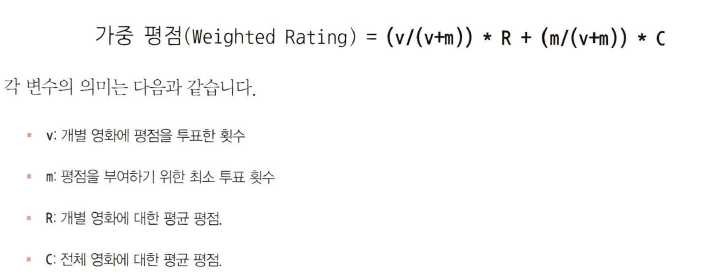

In [15]:
# m= 전체 투표 횟수에서 상위 60%
C = movies_df['vote_average'].mean()
m = movies_df['vote_count'].quantile(0.6)
print('C:', round(C, 3), 'm:', round(m, 3))

C: 6.092 m: 370.2


In [16]:
percentile = 0.6
m = movies_df['vote_count'].quantile(percentile)
C = movies_df['vote_average'].mean()

def weighted_vote_average(record):
  v = record['vote_count']
  R = record['vote_average']

  return ( (v/(v+m)) * R ) + ( (m/(v+m)) * C )

movies_df['weighted_vote'] = movies.apply(weighted_vote_average, axis=1)

In [17]:
# weighted_ote 평점 높은 순 상위 10개
movies_df[['title', 'vote_average', 'weighted_vote', 'vote_count']].sort_values('weighted_vote', ascending=False)[:10]

,title,vote_average,weighted_vote,vote_count
1881,The Shawshank Redemption,8.5,8.396052,8205
3337,The Godfather,8.4,8.263591,5893
662,Fight Club,8.3,8.216455,9413
3232,Pulp Fiction,8.3,8.207102,8428
65,The Dark Knight,8.2,8.136930,12002
1818,Schindler's List,8.3,8.126069,4329
3865,Whiplash,8.3,8.123248,4254
809,Forrest Gump,8.2,8.105954,7927
2294,Spirited Away,8.3,8.105867,3840
2731,The Godfather: Part II,8.3,8.079586,3338


In [18]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
  title_movie = df[df['title']==title_name]
  title_index = title_movie.index.values

  # top_n의 2배에 해당하는 장르 유사성이 높은 인덱스 추출
  similar_indexes = sorted_ind[title_index, :(top_n*2)]
  similar_indexes = similar_indexes.reshape(-1)

  # 기준 영화 인덱스는 제외
  similar_indexes = similar_indexes[similar_indexes != title_index]

  # top_n의 2배에 해당하는 후보군에서 weighted_vote 높은 순으로 top_n 만큼 추출
  return df.iloc[similar_indexes].sort_values('weighted_vote', ascending=False)[:top_n]

similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', 10)
similar_movies[['title', 'vote_average', 'weighted_vote']]

,title,vote_average,weighted_vote
2731,The Godfather: Part II,8.3,8.079586
1847,GoodFellas,8.2,7.976937
3866,City of God,8.1,7.759693
1663,Once Upon a Time in America,8.2,7.657811
883,Catch Me If You Can,7.7,7.557097
281,American Gangster,7.4,7.141396
4041,This Is England,7.4,6.739664
1149,American Hustle,6.8,6.717525
1243,Mean Streets,7.2,6.626569
2839,Rounders,6.9,6.530427
